# Podejmowanie decyzji

## Wstęp

Celem tego laboratorium jest zapoznanie się z kilkoma metodami wykorzystywanymi do podejmowania decyzji
w kontekście, w którym dwa podmioty mają sprzeczne cele, a konkretnie w sytuacji, w której wygrana jednego
podmiotu oznacza przegraną drugiego podmiotu. Wykorzystamy do tego grę w kółko i krzyżyk, która posiada
bardzo proste zasady. Zaprezentowane metody mają jednak znacznie szersze zastosowanie i mogą być wykorzystywane
w szerokim spektrum problemów decyzyjnych.

Zastosowane metody to:

- losowe przeszukiwanie przestrzeni decyzji,
- heurystyczne przeszukiwanie przestrzeni decyzji,
- algorytm minimax,
- algorytm alpha-beta,
- przeszukiwanie w oparciu o metodę Monte Carlo.

Na końcu laboratorium zrobimy turniej graczy zaimplementowanych z użyciem tych metod i zobaczymy, która
metoda razi sobie najlepiej w grze w kółko i krzyżyk.


**NIE WYKONANIE TURNIEJU SKUTKUJE AUTOMATYCZNYM ZEREM**


# Gra w kółko i krzyżyk

Zaczniemy od implementacji gry w kółko i krzyżyk. Możemy podejść do tego na kilka różnych sposobów. Jednym z najprostszych jest gracz wykonujący losowy ruch i liczący na szczęście. Trochę bardziej skomplikowanym graczem będzie gracz wykorzystujący jakąś heurystykę (można taką znaleźć na Wikipedii), nas będą bardziej interesowali gracze oparci o przeszukiwanie drzewa rozgrywki np. algorytmem minimax czy A\*, a w bardziej skomplikowanych problemach znajdują zastosowanie również algorytmy probabilistyczne typu Monte Carlo, a w prostych - klasyczne grafowe przeszukiwanie.


Na początek zaiplemętujemy samą planszę i metody niezbędne do rozgrywki takie jak sprawdzenie, czy ktoś wygrał, wyświetlające stan planszy itd. Poniżej znajduje się implementacja gry, która wyświetla stan gry w fomie tekstowej oraz informuje, kto wygrał grę.


In [ ]:
import numpy as np
from numba import njit

In [ ]:


PLAYER_1 = -1
PLAYER_2 = 1
STRIKE = 3 # same as SIZE, difrent require changes check_for_end() and consequent
SIZE = 3 # same as STRIKE

KERNEL_D1 = np.eye(STRIKE)
KERNEL_D2 = np.rot90(np.eye(STRIKE))


class TicTacToe:
    def __init__(self, player1, player2, size):
        self.size = size
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.player1 = player1
        self.player2 = player2
        self.chars = {0: " ", PLAYER_1: "O", PLAYER_2: "X"}

    def play(self, verbose=True):
        self.print_board(verbose)
        for i in range((self.size*self.size)//2):
            self.player1.move(self.board, PLAYER_1)
            self.print_board(verbose)
            if check_for_end(self.board, PLAYER_1):
                if verbose:
                    print("player 1 wins")
                return "win"
            self.player2.move(self.board, PLAYER_2)
            self.print_board(verbose)
            if check_for_end(self.board, PLAYER_2):
                if verbose:
                    print("player 2 wins")
                return "loss"

        if (self.size % 2) == 1:
            self.player1.move(self.board, PLAYER_1)
            self.print_board(verbose)
            if check_for_end(self.board, PLAYER_1):
                if verbose:
                    print("player 1 wins")
                return "win"
            else:
                if verbose:
                    print("draw")
                return "draw"
        else:
            if verbose:
                    print("draw")
            return "draw"


    def print_board(self, verbose):
        if not verbose:
            return
        str_line = "---------------"
        print("\n" + str_line)
        for row in self.board:
            for cell in row:
                symbol = self.chars[cell]
                print(f"| {symbol} |", end="")
            print("\n" + str_line)

@njit()
def check_for_end(board, player):
    return (
        check_rows(board, player)
        or check_cols(board, player)
        or check_diagonals(board, player)
    )

@njit()
def check_rows(board, player):
    conv = board.sum(axis=0)
    return (np.max(conv * player) )>=STRIKE

@njit()
def check_cols(board, player):
    conv = board.sum(axis=1)
    return (np.max(conv * player))>=STRIKE

@njit()
def check_diagonals(board, player):
    conv = np.multiply(board,KERNEL_D1).sum()
    conv2 = np.multiply(board, KERNEL_D2).sum()
    return (conv* player)>=STRIKE or (conv2* player) >=STRIKE

@njit()
def can_make_move( board, row, col):
    return board[row][col] == 0

@njit()
def get_possible_moves( board):
    res = []
    for j, row in enumerate(board):
        for i, cel in enumerate(row):
            if can_make_move(board, j, i):
                res.append((j, i))

    return res



## Interfejs gracza

Skoro mamy już zdefiniowaną grę to teraz potrzebny jest nam gracz. Poniżej zdefiniowany jest interface PlayerInreface. Należy go wykorzystywać implementując swoich graczy. Interfejs ma metodę `move`, która reprezentuje pojedynczy ruch gracza a także metodę `name`, która zwraca nazwę zaimplementowanego algorytmu.


In [ ]:
from abc import ABC, abstractmethod


class PlayerInterface(ABC):
    @abstractmethod
    def move(self, board, player):
        pass

    @property
    def name(self):
        return type(self).__name__

Zobaczmy, jak wyglądałby prawdopodobnie najprostszy gracz do zaimplementowania, a więc gracz losowy. Wybiera on losowo wiersz i kolumnę, a następnie sprawdza, czy pole jest puste. Jeżeli tak, to stawia tam swój znak.


In [ ]:
import random


class RandomPlayer(PlayerInterface):
    def move(self, board, player):
        while True:
            row, col = random.choice(get_possible_moves(board))
            board[row][col] = player
            return

Sprawdźmy, czy wszystko działa.


In [ ]:
game = TicTacToe(RandomPlayer(), RandomPlayer(),SIZE)
game.play()

Napiszemy teraz kilku kolejnych graczy, podejmujących decyzje nieco inteligentniej, a na koniec zrobimy mały turniej i sprawdzimy, który jest najlepszy.


# Podejmowanie decyzji oparte o heurystykę

W każdym nowym problemie warto sprawdzić proste podejście heurystyczne, wykorzystujące elementarną wiedzę o problemie. Sama gra w kółko i krzyżyk, jak wiadomo, nie jest zbyt skomplikowana. Jest w niej najwyżej 9 możliwych ruchów, mniej niż $3^9 - 1$ możliwych końcowych stanów planszy, a naiwnie licząc, grę można rozegrać na $9!$ sposobów. Dzięki tam mocnemu uproszczeniu istnieje tu strategia optymalna, gwarantująca w najgorszym wypadku remis:


Dla tej gry istnieje [optymalna startegia](https://en.wikipedia.org/wiki/Tic-tac-toe#Strategy) tzn. w najgorszym przypadku zremisujemy.

1. Win: If the player has two in a row, they can place a third to get three in a row.
2. Block: If the opponent has two in a row, the player must play the third themselves to block the opponent.
3. Fork: Cause a scenario where the player has two ways to win (two non-blocked lines of 2).
4. Blocking an opponent's fork: If there is only one possible fork for the opponent, the player should block it. Otherwise, the player should block all forks in any way that simultaneously allows them to make two in a row. Otherwise, the player should make a two in a row to force the opponent into defending, as long as it does not result in them producing a fork. For example, if "X" has two opposite corners and "O" has the center, "O" must not play a corner move to win. (Playing a corner move in this scenario produces a fork for "X" to win.)
5. Center: A player marks the center. (If it is the first move of the game, playing a corner move gives the second player more opportunities to make a mistake and may therefore be the better choice; however, it makes no difference between perfect players.)
6. Opposite corner: If the opponent is in the corner, the player plays the opposite corner.
7. Empty corner: The player plays in a corner square.
8. Empty side: The player plays in a middle square on any of the four sides.


Implementacja takiego bota byłaby jednak niezbyt ciekawa, a na dodatek specyficzna tylko dla tego konkretnego problemu. Dlatego my zajmiemy się eksploracją drzewa gry, a więc możliwych stanów oraz przejść między nimi. Na dobry początek ulepszymy naszego losowego bota trywialną heurystyką - jeżeli to możliwe, ma wybrać ruch wygrywający, a jeżeli nie, to losowy.


Można by też zadać pytanie, czemu nie wykorzystamy tutaj ciekawszego problemu, jak np. szachy. Odpowiedź jest prosta - nie mamy na to czasu, a konkretnie wieczności. Shannon obliczył dolną granicę złożoności drzewa gry na $10^{120}$.


## Wygraj, jeśli to możliwe w kolejnym kroku


## Zadanie 1 (0.5 punkt)

Zaimplementuj ulepszonego losowego bota tak, aby wybierał ruch wygrywający, jeżeli to możliwe, a jeżeli nie, to losowy.


In [ ]:
import copy


class RandomPlayerWinIfCan(PlayerInterface):


    def move(self, board, player):

        # your_code


In [ ]:
game = TicTacToe(RandomPlayerWinIfCan(), RandomPlayer(), SIZE)
game.play()

## Blokuj kolejny krok wygrywający przeciwnika

Skoro w poprzednim zadaniu wygrywamy, kiedy możemy to zrobić w jednym kroku, to spróbujmy ulepszyć naszą strategię wcześniej. Możemy to zrobić, minimalizując swoje straty, czyli sprawdzamy dodatkowo, czy przeciwnik może skończyć grę. Jeżeli tak, to go blokujemy.


## Zadanie 2 (0.5 punkt)

Zaimplementuj ulepszenie bota, w którym dodatkowo jeżeli nie możemy wygrać w danym ruchu, a przeciwnik tak, to go blokujemy. A jeżeli ani my, ani przeciwnik nie może wygrać w kolejnym ruchu, to wykonujemy losowe posunięcie.


In [ ]:
class Blocking(PlayerInterface):

    def move(self, board, player):
        # your_code


In [ ]:
game = TicTacToe(RandomPlayerWinIfCan(), Blocking(), SIZE)
game.play()

# Algorytm minimax

Zaiplemetujemy teraz algorytm minimax. Minimalizuje on nasze maksymalne straty lub maksymalizuje minimalne zyski (maksmin). Poprzednie 2 kroki nas do tego zbliżały. Algorytm wywodzi się z teorii gier o sumie zerowej (gdzie wygrana ma wartość 1, przegrana -1, a remis 0 - w takich grach wygrana jednego gracza, oznacza, że drugi gracz przegrał, czyli nie ma strategii, która prowadziłaby do sytuacji _win-win_).

**Twierdzenie o minimaksie (minimax theorem)** mówi, że dla każdej gry dwuosobowej gry o sumie zerowej istnieje wartość V i mieszana strategia dla każdego gracza, takie, że:

- biorąc pod uwagę strategię gracza drugiego, najlepszą możliwą spłatą dla gracza pierwszego jest V,
- biorąc pod uwagę strategię gracza pierwszego, najlepszą możliwą spłatą dla gracza drugiego jest -V.

Każdy gracz minimalizuje maksymalną możliwą spłatę dla swojego przeciwnika – ponieważ gra jest grą o sumie zerowej, wynikiem tego algorytmu jest również maksymalizowanie swojej minimalnej spłaty.


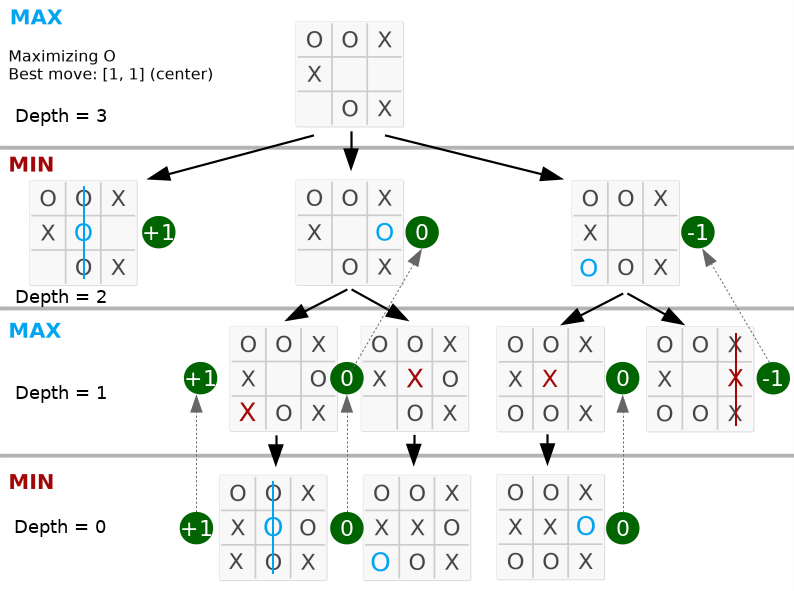


Powyższa ilustracja przedstawia fragment analizy końcowej partii gry w kółko i krzyżyk. **Max** oznacza turę,
w której gracz wybiera ten spośród dostępnych ruchów, który da maksymalną spłatę, natomiast **min** oznacza turę,
w której gracz wybiera ruch, który da minimalną spłatę. Inaczej - _max_ to ruch, z punktu wiedzenia gracza,
dla którego chcemy, żeby wygrał, a _min_ ruch gracza, który chcemy żeby przegrał.

Minimax jest algorytem rekurencyjnym, w którym liście drzewa możliwych ruchów
oznaczają zakończenie gry, z przypisaną do nich wartością z punktu wiedzenia gracza, którego ruch jest w korzeniu
drzewa możliwych ruchów. We wcześniejszych węzłach - w zależności czy jest tura gracza max, czy min, będą wybierane te gałęzie, które maksymalizują, bądź minimalizują wartość spłaty.

Przykładowo - w pierwszym wierszu mamy trzy strzałki i gracza _max_, dlatego gracz ten wybierze pierwszy
możliwy ruch, bo daje on maksymalną spłatę. W drugim wierwszu w środkowej kolumnie mamy dwie strzałki.
Gracz _min_ wybierze zatem strzałkę (ruch) prawy, ponieważ minimalizuje on spłatę (0).
Analogicznie w drugim wierszu po prawej stronie wybierana jest prawa strzałka,
ponieważ daje ona wartość mimalną (-1).

Poniższy diagram zawiera to samo drzewo analizy ruchów, gdzie pozostawiono wyłącznie wartości spłaty dla
poszczególnych węzłów.


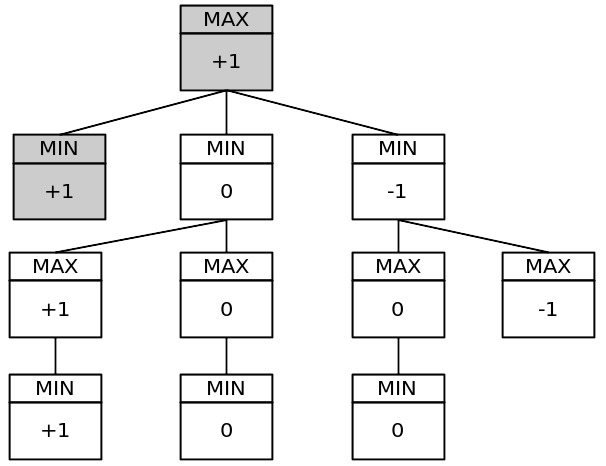


Algorytm _minimax_ jest następujący:

1. zainicalizuj wartość na $-\infty$ dla gracza którego spłata jest maksymalizowana
   i na $+\infty$ dla gracza którego spłata jest minimalizowana,
2. sprawdź czy gra się nie skończyła, jeżeli tak to ewaluuj stan gry z punktu widzenia gracza maksymalizującego i zwróć wynik,
3. dla każdego możliwego ruchu każdego z graczy wywołaj rekurencyjnie _minimax_:
4. przy maksymalizacji wyniku, zwiększ wynik, jeśli otrzymany wynik jest większy od dotychczas największego wyniku,
5. przy minimalizacji wyniku, pomniejsz wynik, jeśli otrzymany wynik jest mniejszy od dotychczas najmniejszego wyniku,
6. zwróć najlepszy wynik.

Algorytm ten wymaga dodatkowo funkcji ewaluującej, która oceni stan gry na końcu. Uznajemy, że zwycięstwo to +1, przegrana -1, a remis 0.


## Zadanie 3 (2 punkty)

Zaimplementuj gracza realizującego algorytm minimaks.


In [ ]:
from math import inf


class MinimaxPlayer(PlayerInterface):
    def move(self, board, player):

        # your_code


In [ ]:
%%time
game = TicTacToe(MinimaxPlayer(), Blocking(), SIZE)
game.play()

Wróć na chwilę do implementacji minimaxu i zastanów się, co się dzieje, jeżeli ten algorytm wykonuje ruch na pustej planszy i jak to wpływa na jego czas działania. Może coś można poprawić?


# Alpha-beta pruning

Widzimy, że nasz poprzedni gracz jest właściwie idealny, bo w końcu sprawdza całe drzewo gry. Ma tylko w związku z tym wadę - dla większości problemów wykonuje się wieczność. Dlatego też zastosujemy ważne ulepszenie algorytmu minimax, nazywane alfa-beta pruning.

W przypadku klasycznego minimaxu ewaluujemy każdą możliwą ścieżkę gry. Alfa-beta pruning, jak i wiele innych metod, opiera się na "przycinaniu" drzewa, czyli nie ewaluujemy tych odnóg drzewa, co do których wiemy, że nie da ona lepszego wyniku niż najlepszy obecny. W niektórych wypadkach, np. w dobrej implementacji dla szachów, potrafi zredukować liczbę rozważanych ścieżek nawet o 99.8%.


Do poprzedniego algorytmu dodajemy 2 zmienne, $\alpha$ i $\beta$:

- $\alpha$ przechowuje najlepszą wartość dla gracza maksymalizującego swój wynik,
- $\beta$ przechowuje najlepszą wartość dla gracza minimalizującego swój wynik.

Dzięki tej informacji możemy przerwać sprawdzanie danej gałęzi, kiedy $\alpha$ jest większa od $\beta$. Oznacza to bowiem sytuację, w której najlepszy wynik gracza maksymalizującego jest większy niż najlepszy wynik gracza minimalizującego.


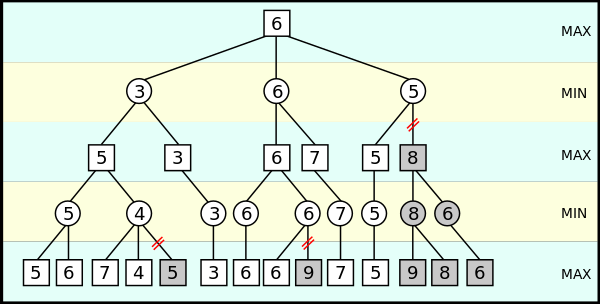


Pseudokod:

```
function alphabeta(node, depth, α, β, maximizingPlayer) is
    if depth = 0 or node is a terminal node then
        return the heuristic value of node
    if maximizingPlayer then
        value := −∞
        for each child of node do
            value := max(value, alphabeta(child, depth − 1, α, β, FALSE))
            α := max(α, value)
            if α ≥ β then
                break (* β cutoff *)

        return value
    else
        value := +∞
        for each child of node do
            value := min(value, alphabeta(child, depth − 1, α, β, TRUE))
            β := min(β, value)
            if α ≥ β then
                break (* α cutoff *)
        return value
```


## Zadanie 4 (2 punkty)

Zaimplementuj gracza realizującego algorytm alfa-beta pruning, zmodyfikuj funkcje ewaluacji tak by preferowała szybkie zwycięstwo i penalizowała szybką porażkę.


In [ ]:
class AlphaBetaPlayer(PlayerInterface):
    def move(self, board, player):

        # your_code


In [ ]:
%%time
game = TicTacToe(AlphaBetaPlayer(), MinimaxPlayer(), SIZE)
game.play()

# Monte Carlo Tree Search (MCTS)

Metody Monte Carlo polegają na wprowadzeniu losowości i przybliżaniu za jej pomocą rozwiązań dla trudnych problemów. Dla gry w kółko i krzyżyk nie jest to co prawda niezbędne, ale dla bardziej skomplikowanych gier, jak szachy czy go, już zdecydowanie tak.

Ogólna metoda MCTS składa się z 4 etapów:

- selekcji - wybieramy najlepsze dziecko, aż dotrzemy do liścia,
- ekspansji - jeżeli nie możemy dokonać selekcji, rozwijamy drzewo we wszystkich możliwych kierunkach z węzła,
- symulacji - po ekspansji wybieramy węzeł do przeprowadzenia symulacji gry aż do końca,
- wstecznej propagacji - kiedy dotrzemy do końca, ewaluujemy wynik gry i propagujemy go w górę drzewa.

W naszym wypadku wystarczy nieco prostszy algorytm Pure Monte Carlo Tree Search (Pure MCTS), w którym realizujemy tylko symulację i wsteczną propagację. Dla każdego możliwego ruchu w danej rundzie przeprowadzamy N symulacji oraz obliczamy prawdopodobieństwo zwycięstwa/remisu/przegranej dla każdego z możliwych ruchów, a następnie wybieramy najlepszy ruch.


## Zadanie 5 (2 punkty)

Zaimplementuj gracza realizującego algorytm Pure MCTS.


In [ ]:
class MonteCarloPlayer(PlayerInterface):
    def move(self, board, player):

        # your_code


In [ ]:
%%time
game = TicTacToe(MonteCarloPlayer(), MinimaxPlayer(), SIZE)
game.play()

## Turniej - zadanie specjalne!

Teraz przeprowadzimy turniej w celu porównania zaimplementowanych metod. Każdy algorytm będzie grał z każdym po 10 razy.

**NIE WYKONANIE TURNIEJU SKUTKUJE AUTOMATYCZNYM ZEREM ZA CAŁOŚĆ LABORATORIUM**

Należy go wykonać nwet wtedy gdy nie wszystkie algorytmy zostały zaimplementowane.


In [ ]:
from collections import defaultdict
from IPython.display import display
import pandas as pd


def print_scores(scores, names):
    win = {}
    for name in names:
        win[name] = [scores["win"][name][n] for n in names]
    loss = {}
    for name in names:
        loss[name] = [scores["loss"][name][n] for n in names]
    draw = {}
    for name in names:
        draw[name] = [scores["draw"][name][n] for n in names]

    df = pd.DataFrame.from_dict(win, orient="index", columns=names)
    display(df)
    df2 = pd.DataFrame.from_dict(loss, orient="index", columns=names)
    display(df2)
    df3 = pd.DataFrame.from_dict(draw, orient="index", columns=names)
    display(df3)

In [ ]:
%%time

number_of_rounds = 10
players = [
    RandomPlayer(),
    Blocking(),
    RandomPlayerWinIfCan(),
    MinimaxPlayer(),
    AlphaBetaPlayer(),
    MonteCarloPlayer(),
]
scores = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for player in players:
    for adversary in players:
        for i in range(number_of_rounds):
            game = TicTacToe(player, adversary, SIZE)
            score = game.play(False)
            # print("player name {} adversary name {} score {} ".format(player.name, adversary.name, score))
            scores[score][player.name][adversary.name] += 1


print_scores(scores, [player.name for player in players])

# Zadanie dodatkowe (3 punkty)

Rozwiń kod algorytmu MCTS tak, aby działał z ogólnymi zasadami, a nie w formie uproszczonego Pure MCTS.

Zastosuj prosty, ale bardzo skuteczny sposób selekcji UCT (_Upper Confidence Bound 1 applied to trees_), będący wariantem bardzo skutecznych metod UCB, stosowanych m.in. w podejmowaniu decyzji, uczeniu ze wzmocnieniem i systemach rekomendacyjnych. Polega na wyborze tego węzła, dla którego następujące wyrażenie ma maksymalną wartość:

$$
\large
\frac{w_i}{n_i} + c\sqrt\frac{\ln N_i}{n_i}
$$

gdzie:

- $w_i$ to liczba zwycięstw dla węzła po rozważeniu $i$-tego ruchu
- $n_i$ to łączna liczba symulacji przeprowadzonych dla węzła po $i$-tym ruchu,
- $N_i$ oznacza całkowitą liczbę symulacji przeprowadzoną po $i$-tym ruchu dla węzła-rodzica aktualnie rozważanego węzła,
- $c$ to hiperparametr, wedle teorii powinien mieć wartość $\sqrt{2}$.

O uzasadnieniu tego wzoru możesz więcej przeczytać [tutaj](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search#Exploration_and_exploitation).

Jeżeli chcesz, możesz zastosować ten algorytm dla bardziej skomplikowanej gry, jak np. warcaby czy szachy.
